## Постановка задачи

Разработать алгоритм прогнозирующий наиболее вероятную категорию события дорожно-транспортного происшествия (далее по тексту «ДТП»):

>1. ДТП не произойдет
>1. ДТП произойдет без пострадавших
>1. ДТП произойдет с пострадавшими

Данные для обучения — информация о ДТП от ГИБДД и ВНИИ ГОЧС, а также дополнительные данные по интенсивности движения, метеоусловиях на участках дороги и др. В качестве федеральных автомобильных дорог рассматриваются М-8 «Холмогоры» и Р-21 «Кола».

In [15]:
pip install swifter --user

     |████████████████████████████████| 634kB 49.4MB/s eta 0:00:01
     |████████████████████████████████| 296kB 66.3MB/s eta 0:00:01
     |████████████████████████████████| 931kB 75.4MB/s eta 0:00:01
     |████████████████████████████████| 81kB 16.4MB/s eta 0:00:01
     |████████████████████████████████| 286kB 81.0MB/s eta 0:00:01
     |████████████████████████████████| 573kB 75.1MB/s eta 0:00:01
     |████████████████████████████████| 61kB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 112kB 81.0MB/s eta 0:00:01
     |████████████████████████████████| 40kB 9.6MB/s  eta 0:00:01
     |████████████████████████████████| 49.7MB 14.7MB/s eta 0:00:01
     |████████████████████████████████| 17.2MB 77.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 78.0MB/s eta 0:00:01
     |████████████████████████████████| 102kB 18.3MB/s ta 0:00:01
     |████████████████████████████████| 1.0MB 70.5MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 72.0MB/s eta 0:00:

## Прототип решения

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
import functools
from geopy.distance import geodesic
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np
import swifter
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from pathlib import Path
import argparse

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### 1. Подготовка датасета для обучения модели

In [5]:
df = pd.read_pickle('data/train-v4.pickle')
df.datetime = df.datetime.apply(pd.to_datetime)
df = df.sort_values('datetime', ascending=True)
df.reset_index(drop=True, inplace=True)
df.head(2)

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target
0,2012-01-01 12:00:00,14,1276,1,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,33.319,68.212,gochs,2
1,2012-01-01 22:00:00,9,278,2,0,3.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",0.000,0.000,gochs,2


#### Тренеровочный датасет (`train.csv`):
> 1. **datetime** - дата события в формате `yyyy-MM-dd hh-mm-ss`
> 1. **road_id** - код автодороги, принимает одно из трех значений:
>    * 5 — М-4 (E115) “Дон” Москва - Новороссийск;
>    * 9 — М-8 (E115) “Холмогоры” Москва - Архангельск через Ярославль, Вологду;
>    * 4 — М-18 / Р-21 (E105) “Кола” С.Петербург - Мурманск через Петрозаводск.
> 1. **road_km** - км участка на котором произошло ДТП
> 1. **data_source** - источник данных события. В датасете атрибут принимает одно из двух значений:
>    * gibdd - ГИБДД;
>    * gochs - МЧС.
> 1. **target** - целевой признак является ли событие ДТП. В датасете атрибут принимает одно из четырех значений:
>    * 1 - ДТП без пострадавших;
>    * 2 - ДТП с пострадавшими;
>    * 3 - ЧС (объявляется от 5 погибших и/или 10 пострадавших)* в тестовой выборке события отсутствуют0 - событие не является ДТП;

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112317 entries, 0 to 112316
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   datetime         112317 non-null  datetime64[ns]
 1   road_id          112317 non-null  int64         
 2   road_km          112317 non-null  int64         
 3   man_injured_num  112317 non-null  int64         
 4   man_dead_num     112317 non-null  int64         
 5   car_damaged_num  104584 non-null  float64       
 6   road_name        112317 non-null  object        
 7   lon              58046 non-null   float64       
 8   lat              58046 non-null   float64       
 9   data_source      112317 non-null  object        
 10  target           112317 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 9.4+ MB


In [7]:
df.road_id.value_counts()

5     61126
9     34570
14    16621
Name: road_id, dtype: int64

In [8]:
start = df.datetime.min()
end = df.datetime.max()
print("Временной интервал наблюдений: от {} до {}".format(start,end))
gibdd = df.groupby('data_source')['road_id'].count()[0]
mchs = df.groupby('data_source')['road_id'].count()[1]
print("Кол-во наблюдений по источникам данных: ГИБДД - {}, МЧС {}".format(gibdd,mchs))

Временной интервал наблюдений: от 2012-01-01 12:00:00 до 2021-04-05 11:00:00
Кол-во наблюдений по источникам данных: ГИБДД - 96999, МЧС 15318


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112317 entries, 0 to 112316
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   datetime         112317 non-null  datetime64[ns]
 1   road_id          112317 non-null  int64         
 2   road_km          112317 non-null  int64         
 3   man_injured_num  112317 non-null  int64         
 4   man_dead_num     112317 non-null  int64         
 5   car_damaged_num  104584 non-null  float64       
 6   road_name        112317 non-null  object        
 7   lon              58046 non-null   float64       
 8   lat              58046 non-null   float64       
 9   data_source      112317 non-null  object        
 10  target           112317 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 9.4+ MB


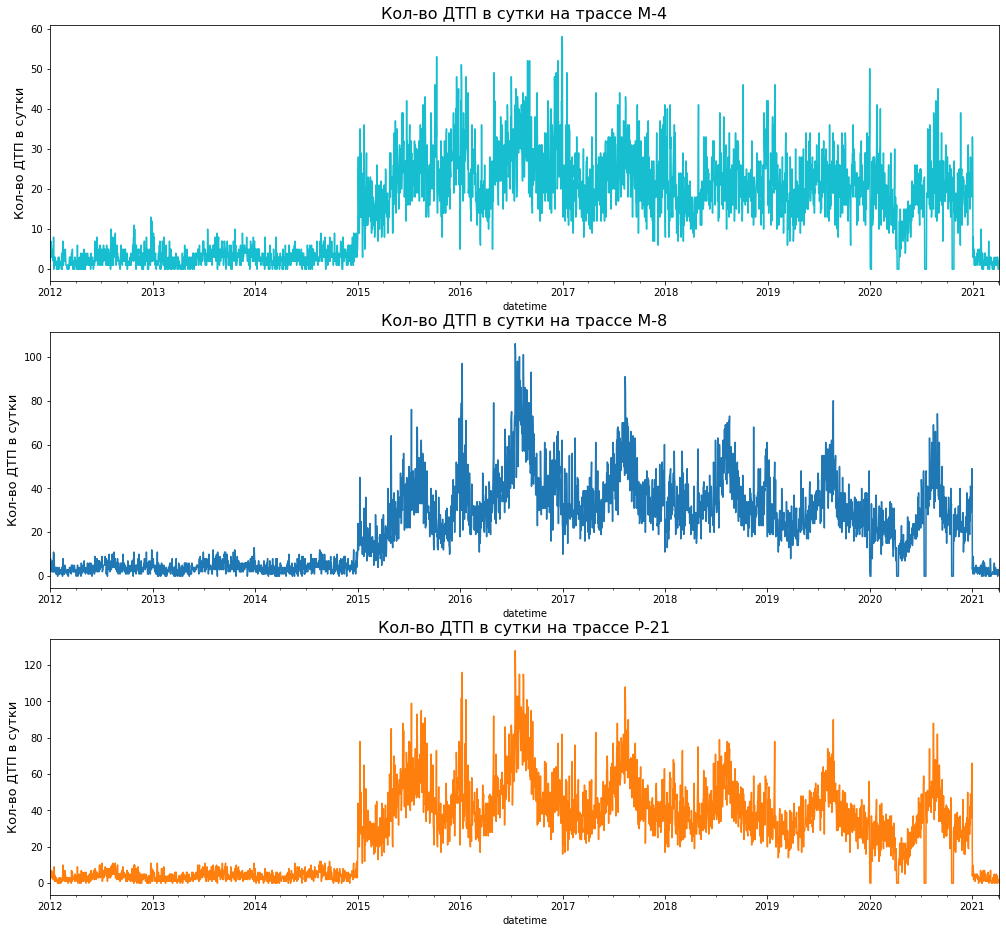

In [10]:
# распределение ДТП в расрезе трех трасс
fig, ax = plt.subplots(figsize=(17,16), ncols=1, nrows=3)

road_5 = df.drop(df[df["road_id"]==5].index)
road_9 = df.drop(df[df["road_id"]==9].index)
road_14 = df.drop(df[df["road_id"]==14].index)

dtp_day_5 = road_5[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_9 = road_9[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_14 = road_14[['datetime', 'target']].set_index('datetime').resample('D').count()['target']

dtp_day_5.plot(color='tab:cyan', ax=ax[0]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_9.plot(color='tab:blue', ax=ax[1]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_14.plot(color='tab:orange', ax=ax[2]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)

ax[0].set_title('Кол-во ДТП в сутки на трассе М-4',loc='center', fontsize=16)
ax[1].set_title('Кол-во ДТП в сутки на трассе М-8',loc='center', fontsize=16)
ax[2].set_title('Кол-во ДТП в сутки на трассе Р-21',loc='center', fontsize=16)
plt.show()

На временном интервале от 2012-01-01 до 2021-04-05 можно наблюдать разброс в количестве аварий по дням в разрезе лет: так, с 2016 года суточный показатель ДТП значительно больше по каждой из рассматриваемых трасс. Такой разброс объясняетсся различной представленностью данных МЧС (15059) и ГИБДД (94678 наблюдений) с отсутствием последних на интервале 2012-2015 гг. (см. график ниже). 

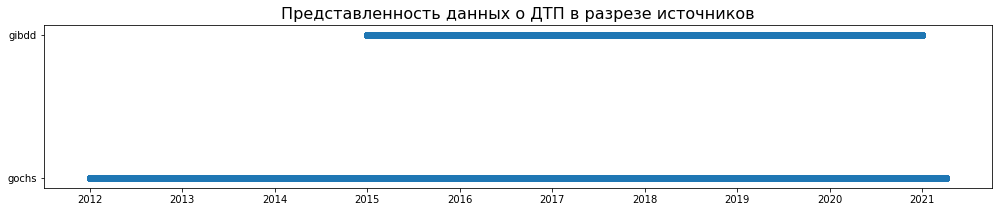

In [11]:
fig, ax = plt.subplots(figsize=(17,3))
plt.scatter(road_9['datetime'], road_9['data_source'])
ax.set_title('Представленность данных о ДТП в разрезе источников',loc='center', fontsize=16)
plt.show()

Для дальнейшего обучения модели **выберем данные о ДТП трассам М8 и Р21 (трасса М4 отсутствует в тестовой выборке, и для нее также нет многих данных)**. Рассмотрим ситуацию для всех значений переменной `target`. Выберем период наблюдения с 2016-01-01 по 2020-12-31, заполним промежутки между наблюдениями на всем временном интервале нулевыми значениями с шагом в один час, присвоив значения 0 (событие не является ДТП) переменной `target`, и обогатим исходную выборку переменными из других датасетов.

In [12]:
START_TRAIN_DATE = '2019-01-01'
END_TRAIN_DATE = '2020-12-31'

def filter_by_dates(df, start_date, train_date, datetime_col = 'datetime'):
    date_condition1 = (df[datetime_col] >= start_date)
    date_condition2 = (df[datetime_col] <= train_date)
    return df[date_condition1 & date_condition2]

In [13]:
df = filter_by_dates(df, START_TRAIN_DATE, END_TRAIN_DATE)
df = df.loc[df.road_id != 5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14017 entries, 82777 to 111926
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         14017 non-null  datetime64[ns]
 1   road_id          14017 non-null  int64         
 2   road_km          14017 non-null  int64         
 3   man_injured_num  14017 non-null  int64         
 4   man_dead_num     14017 non-null  int64         
 5   car_damaged_num  14017 non-null  float64       
 6   road_name        14017 non-null  object        
 7   lon              14011 non-null  float64       
 8   lat              14011 non-null  float64       
 9   data_source      14017 non-null  object        
 10  target           14017 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 1.3+ MB


In [14]:
df.target.value_counts()

1    11361
2     2652
3        4
Name: target, dtype: int64

Как видно, данные не сбалансированы по классам. Данные из класса 3 перенесем в класс 2

In [15]:
df.loc[df.target == 3, 'target'] = 2
df.target.value_counts()

1    11361
2     2656
Name: target, dtype: int64

#### Обагащение выборки переменными из остальных датасетов

In [16]:
traffic = pd.read_pickle('data/traffic.pickle')
repair = pd.read_pickle('data/repair.pickle')
crash_parts = pd.read_pickle('data/crash_parts.pickle')
atmos = pd.read_pickle('data/atmos.pickle')
geo_data = pd.read_pickle('data/geo_data.pickle')
meteo = pd.read_pickle('data/meteo.pickle')

In [17]:
r21_attributes = pd.read_pickle('data/Р-21-атрибуты.pickle')

### TODO: исследовать Р21 аттрибуты

In [18]:
r21_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209385 entries, 0 to 209384
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 209385 non-null  int64  
 1   way_id                  209385 non-null  int64  
 2   way_version             209385 non-null  int64  
 3   way_status              209385 non-null  object 
 4   point_status            209385 non-null  object 
 5   processed_date          209385 non-null  object 
 6   way_sort_order          209385 non-null  int64  
 7   point_sort_order        209385 non-null  int64  
 8   lat                     209385 non-null  int64  
 9   lon                     209385 non-null  int64  
 10  direction               209385 non-null  bool   
 11  photo_name              0 non-null       float64
 12  photo_date              209125 non-null  object 
 13  vehicle_occupant_score  209385 non-null  float64
 14  motorcyclist_score  

In [19]:
r21_attributes.head()

,user_id,way_id,way_version,way_status,point_status,processed_date,way_sort_order,point_sort_order,lat,lon,direction,photo_name,photo_date,vehicle_occupant_score,motorcyclist_score,bicyclist_score,pedestrian_score,item_code,item_name,user_attribute_number,user_attribute_name,ml_attribute_number,ml_attribute_name,osm_attribute_number,osm_attribute_name,OSM_tags
0,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,13,Carriageway label,3,Undivided road,NaN,NaN,NaN,NaN,NaN
1,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,20,Land use - driver-side,1,Undeveloped areas,NaN,NaN,NaN,NaN,NaN
2,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,21,Land use – passenger-side,1,Undeveloped areas,NaN,NaN,NaN,NaN,NaN
3,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,22,Area type,1,Rural,NaN,NaN,NaN,NaN,NaN
4,85,640977410,2,PROCESSED,PROCESSED,2021-04-15 13:16:11.165,0,1,598887107,312377870,True,NaN,2019-06-01 03:00:00.0,16.21,21.365,106.319,74.197,23,Speed limit,13,90km/h,NaN,NaN,NaN,NaN,NaN


In [20]:
r21_attributes.item_name.value_counts()

Ped flow along                                     7940
Paved shoulder - driver-side                       3970
Roadside severity – driver-side distance           3970
Road category                                      3970
Centre line rumble strips                          3970
Speed limit                                        3970
Curvature                                          3970
Land use - driver-side                             3970
Pedestrian crossing facilities – inspected road    3970
Roadside width                                     3970
Facilities for motorcycles                         3970
Visibility distance                                3970
Delineation                                        3970
Paved shoulder – passenger-side                    3970
Roadworks                                          3970
Intersection quality                               3970
Quality of curve                                   3970
Area type                                       

In [21]:
r21_attributes.loc[r21_attributes.item_name == 'Quality of curve'].user_attribute_name.value_counts()

Not applicable    3029
Adequate           929
Poor                12
Name: user_attribute_name, dtype: int64

### TODO: исследовать traffic.csv

In [22]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7343154 entries, 0 to 7343153
Data columns (total 14 columns):
 #   Column      Dtype         
---  ------      -----         
 0   datetime    datetime64[ns]
 1   road_id     int64         
 2   road_km     int64         
 3   name        object        
 4   data_id     int64         
 5   station_id  int64         
 6   lane        int64         
 7   lane_count  int64         
 8   direction   object        
 9   volume      float64       
 10  occupancy   float64       
 11  speed       float64       
 12  latitude    float64       
 13  longitude   float64       
dtypes: datetime64[ns](1), float64(5), int64(6), object(2)
memory usage: 784.3+ MB


In [23]:
traffic.head()

,datetime,road_id,road_km,name,data_id,station_id,lane,lane_count,direction,volume,occupancy,speed,latitude,longitude
0,2016-01-01 00:59:59,9,527,км 526+700,9505403,41108,1,1,backward,32.0,0.80,68.00,59.638016,40.561815
1,2016-01-01 00:59:59,9,181,км 181+000,9898469,40721,1,1,backward,39.0,1.00,73.33,57.001636,39.247588
2,2016-01-01 00:59:59,9,327,км 327+300,9505642,41123,2,2,forward,72.0,1.49,86.00,58.139795,40.141995
3,2016-01-01 00:59:59,9,327,км 327+300,9505642,41123,1,2,forward,4.0,8.00,42.00,58.139795,40.141995
4,2016-01-01 00:59:59,9,327,км 327+300,9505642,41123,1,2,backward,92.0,1.92,75.30,58.139795,40.141995


In [24]:
traffic = filter_by_dates(traffic, START_TRAIN_DATE, END_TRAIN_DATE)

In [25]:
traffic.road_id.value_counts()

9     1277860
14    1155898
Name: road_id, dtype: int64

Отсутствуют данные по траффику на дороге 5

In [26]:
traffic.drop_duplicates(inplace = True)

In [27]:
traffic.lane.value_counts()

1    1717763
2     597794
3     102260
6       5314
4       5314
5       5313
Name: lane, dtype: int64

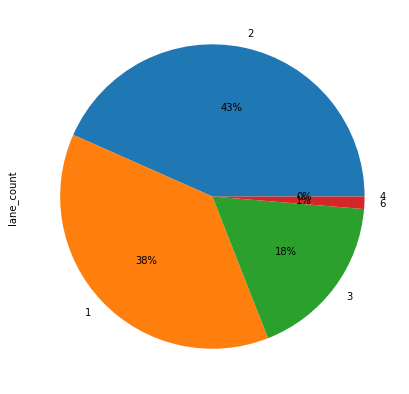

In [28]:
traffic.lane_count.value_counts().plot(kind = 'pie', figsize = (7, 7), autopct='%1.0f%%');

In [29]:
traffic.direction.value_counts()

backward    1237085
forward     1196673
Name: direction, dtype: int64

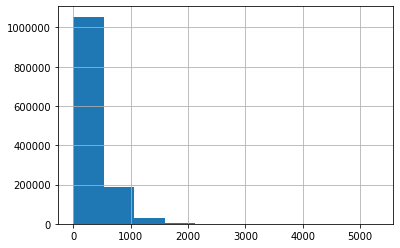

In [30]:
traffic.loc[traffic.road_id == 9].volume.hist()

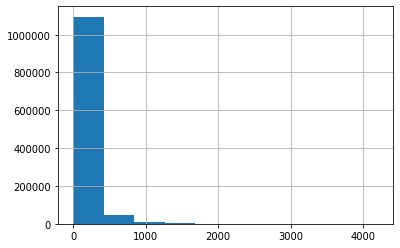

In [31]:
traffic.loc[traffic.road_id == 14].volume.hist()

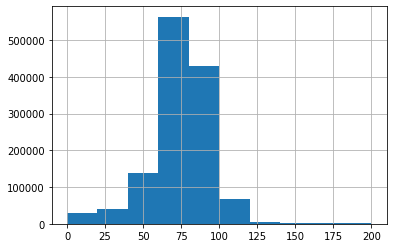

In [32]:
traffic.loc[traffic.road_id == 9].speed.hist()

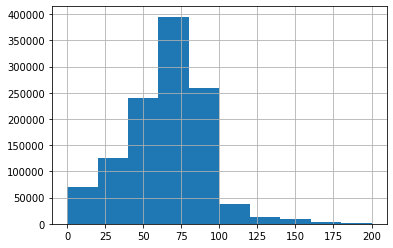

In [33]:
traffic.loc[traffic.road_id == 14].speed.hist()

### Анализ данных об аварийных участках (crash_parts)

In [34]:
crash_parts = filter_by_dates(crash_parts, START_TRAIN_DATE, END_TRAIN_DATE)

In [35]:
crash_parts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 62 to 166
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       65 non-null     int64         
 1   datetime         65 non-null     datetime64[ns]
 2   road_id          65 non-null     int64         
 3   road_km          65 non-null     int64         
 4   avuch_start      65 non-null     float64       
 5   avuch_end        65 non-null     float64       
 6   length           65 non-null     int64         
 7   avuch_loc        65 non-null     int64         
 8   stabchar_type    65 non-null     int64         
 9   planactiv_type   65 non-null     int64         
 10  planactiv_descr  65 non-null     object        
 11  planactiv_year   65 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(7), object(1)
memory usage: 6.6+ KB


In [36]:
crash_parts.head()

,Unnamed: 0,datetime,road_id,road_km,avuch_start,avuch_end,length,avuch_loc,stabchar_type,planactiv_type,planactiv_descr,planactiv_year
62,62,2019-01-01,9,119,119.078,119.106,30,1,3,4,1. Установить светофорный объект с кнопкой вызова пешеходом.\n2. Установка перильного ограждения по ГОСТ Р 52289-2004.\n3. Установка стационарного комплекса автоматической фиксации нарушений ПДД.\n4. Размещение знаков 1.34.1 и 1.34.2 на щитах с флуоресцентной пленкой желто-зеленого цвета.\n5. Светодиодная подсветка светофора.\n6. Установить щиты аварийно-опасный участок.,2020-12-31
63,63,2019-01-01,9,122,122.279,122.480,201,2,1,4,1. Ввести ограничения скоростного режима до 70 км/ч на участке км 122+000 – км 122+700. Внести изменения в ПОДД. \n2. Установка передвижного комплекса автоматической фиксации нарушений ПДД.\n3. Установить щиты аварийно-опасный участок.,2020-12-31
64,64,2019-01-01,9,133,133.400,134.400,1000,2,1,4,"1. Установка стационарного комплекса автоматической фиксации нарушений ПДД.\n2. Ограничение скорости до 70 км/ч, устройство шумовых полос.\n3. Установка кнопки дистанционного управления светофором с поста ДПС.\n4. Светодиодная подсветка светофора.\n5. Установить щиты аварийно-опасный участок.\n6. Проработать вопрос устройства перекрестка с круговым движением.\n",2020-12-31
65,65,2019-01-01,9,134,133.400,134.400,1000,2,1,4,"1. Установка стационарного комплекса автоматической фиксации нарушений ПДД.\n2. Ограничение скорости до 70 км/ч, устройство шумовых полос.\n3. Установка кнопки дистанционного управления светофором с поста ДПС.\n4. Светодиодная подсветка светофора.\n5. Установить щиты аварийно-опасный участок.\n6. Проработать вопрос устройства перекрестка с круговым движением.\n",2020-12-31
66,66,2019-01-01,9,169,169.280,169.830,550,2,3,4,1. Ограничение скорости до 70 км/ч с устройством шумовых полос и установкой дорожных знаков 1.16 «Неровная дорога». \n2. Дублирование дорожных знаков 3.20 «Обгон запрещен» и размещение их на щитах с флуорисцентной пленкой желто-зеленого цвета.\n3. Установить щиты аварийно-опасный участок.,2020-12-31


In [37]:
crash_parts.planactiv_descr.value_counts()

1. Установить щиты аварийно-опасный участок.\n2. Установка стационарного комплекса автоматической фиксации нарушений ПДД.\n3. Рассмотреть вопрос устройства шумовых полос.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [38]:
len(crash_parts.planactiv_descr.value_counts())

43

In [39]:
crash_parts.road_id.value_counts()

9     59
14     6
Name: road_id, dtype: int64

In [40]:
crash_parts.datetime.value_counts()

2020-01-01    36
2019-01-01    29
Name: datetime, dtype: int64

In [41]:
crash_parts.stabchar_type.value_counts()

3    39
2    13
1    13
Name: stabchar_type, dtype: int64

характеристика стабильности местоположения участка концентрации ДТП. Принимает следующие 3 значения:
• 1 - Стабильный;
• 2 - Мигрирующий (подразумевается варьирующий характер частоты ДТП на
данном участке при сравнении по годам);
• 3 - Вновь возникший (подразумевает возникновение нескольких аварийно опасных
ситуаций в рамках одного года).

In [42]:
crash_parts.planactiv_type.value_counts()

4    63
2     1
1     1
Name: planactiv_type, dtype: int64

код планируемого/планируемых работ на данном участке. Принимает следующие 4 значения:
• 1 - реконструкция;
• 2 - капитальный ремонт;
• 3 - ремонт;
• 4 - содержание.

#### TODO: Важная фича - произошло ли событие на аварийном участке.

In [43]:
df.head()

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target
82777,2019-01-01 00:00:00,9,653,0,0,2.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",41.698093,60.530978,gibdd,1
82778,2019-01-01 02:00:00,14,1184,0,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,32.492065,67.430904,gibdd,1
82779,2019-01-01 04:00:00,14,438,1,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,34.249245,61.901929,gibdd,2
82781,2019-01-01 05:00:00,14,440,1,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,0.000000,0.000000,gochs,2
82786,2019-01-01 10:00:00,9,962,0,0,2.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",42.724328,62.851171,gibdd,1


In [44]:
def is_on_crash_part(row):
    road_id = row['road_id']  
    if road_id != 5:
        road_crash_parts = crash_parts.loc[crash_parts['road_id'] == road_id]
        for index, crash_part in road_crash_parts.iterrows():
            if crash_part['road_km'] <= row['road_km'] <= round(crash_part['avuch_end']):
                return True
        
    return False

### TODO: Анализ данных о погоде (бранч feature-weather)

In [45]:
# фильтр датасетов по заданным уловиям
repair = filter_by_dates(repair, START_TRAIN_DATE, END_TRAIN_DATE)

repair.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710 entries, 41 to 2860
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            710 non-null    datetime64[ns]
 1   road_id             710 non-null    int64         
 2   road_km             710 non-null    int64         
 3   repair_id           710 non-null    int64         
 4   repair_description  710 non-null    object        
 5   repair_period       710 non-null    object        
 6   length              709 non-null    float64       
 7   price               710 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 49.9+ KB


In [46]:
def hour_rounder(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [47]:
# округление переменной datetime до часа
traffic['datetime'] = traffic['datetime'].map(lambda x: hour_rounder(x))

In [48]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433758 entries, 2106972 to 7141751
Data columns (total 14 columns):
 #   Column      Dtype         
---  ------      -----         
 0   datetime    datetime64[ns]
 1   road_id     int64         
 2   road_km     int64         
 3   name        object        
 4   data_id     int64         
 5   station_id  int64         
 6   lane        int64         
 7   lane_count  int64         
 8   direction   object        
 9   volume      float64       
 10  occupancy   float64       
 11  speed       float64       
 12  latitude    float64       
 13  longitude   float64       
dtypes: datetime64[ns](1), float64(5), int64(6), object(2)
memory usage: 278.5+ MB


Сделаем аггрегацию траффика по времени и км дороги

In [49]:
traffic_agg = traffic.groupby(['datetime', 'road_id', 'road_km']).mean().reset_index()
traffic_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874015 entries, 0 to 874014
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   datetime    874015 non-null  datetime64[ns]
 1   road_id     874015 non-null  int64         
 2   road_km     874015 non-null  int64         
 3   data_id     874015 non-null  float64       
 4   station_id  874015 non-null  float64       
 5   lane        874015 non-null  float64       
 6   lane_count  874015 non-null  float64       
 7   volume      874015 non-null  float64       
 8   occupancy   874015 non-null  float64       
 9   speed       874015 non-null  float64       
 10  latitude    874015 non-null  float64       
 11  longitude   874015 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 80.0 MB


In [50]:
len(traffic_agg.loc[(traffic_agg.volume == 0) | (traffic_agg.volume.empty)])

9063

In [51]:
traffic_agg = traffic_agg.loc[(traffic_agg.volume != 0)]

In [52]:
traffic_agg.head()

,datetime,road_id,road_km,data_id,station_id,lane,lane_count,volume,occupancy,speed,latitude,longitude
0,2019-01-01 01:00:00,9,126,27435837.0,52815.0,1.0,1.0,43.500000,1.099609,74.977500,56.650789,38.696885
1,2019-01-01 01:00:00,9,181,27436565.0,40721.0,1.0,1.0,33.500000,1.000000,62.915000,57.001636,39.247588
3,2019-01-01 01:00:00,9,254,27435821.0,52836.0,2.0,3.0,32.333333,0.568359,82.413333,57.546999,39.804700
4,2019-01-01 01:00:00,9,274,27457669.0,41124.0,1.5,2.0,93.500000,3.072500,80.725000,57.695934,39.899008
5,2019-01-01 01:00:00,9,279,27582705.0,41134.0,1.0,2.0,16.500000,5.200000,75.500000,57.739604,39.896970


После мержа с тренировочными данными остается много пустых полей о траффике. Для поиска недостающих полей напишем функцию, которая находит наиболее актуальные данные о траффике, используя ближайшую камеру и время.

In [53]:
def get_nearest_datetime(df, dtp_datetime):
    return df.iloc[np.argmin(np.abs(df.datetime - dtp_datetime))]


def fill_dtp_with_nearest_traffic_rec(dtp_row):
    tmp = traffic_agg.loc[traffic_agg['road_id'] == dtp_row.road_id]
    nearest_traffic_road_km = tmp.iloc[(tmp['road_km'] - dtp_row.road_km).abs().argsort()[:1]].road_km.iloc[0]
    nearest_traffic_datetime = get_nearest_datetime(tmp.loc[tmp.road_km == nearest_traffic_road_km], dtp_row.datetime).datetime

    nearest_traffic_rec = tmp.loc[(tmp.road_km == nearest_traffic_road_km) & (tmp.datetime == nearest_traffic_datetime)]
    
    nearest_traffic_rec.reset_index(drop=True, inplace=True)

    return nearest_traffic_rec.lane.values[0], nearest_traffic_rec.lane_count.values[0], nearest_traffic_rec.volume[0], nearest_traffic_rec.occupancy[0], nearest_traffic_rec.speed[0]

fill_dtp_with_nearest_traffic_rec(df.iloc[1])

(1.3333333333333333, 2.0, 4.0, 0.33984375, 80.98)

In [54]:
df['lane'] = np.nan
df['lane_count'] = np.nan
df['volume'] = np.nan 
df['occupancy'] = np.nan
df['speed'] = np.nan

df['lane'], df['lane_count'], df['volume'], df['occupancy'], df['speed'] = zip(*df.swifter.apply(fill_dtp_with_nearest_traffic_rec, axis = 1))

Pandas Apply:   0%|          | 0/14017 [00:00<?, ?it/s]

In [55]:
df.head()

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target,lane,lane_count,volume,occupancy,speed
82777,2019-01-01 00:00:00,9,653,0,0,2.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",41.698093,60.530978,gibdd,1,1.000000,1.0,14.0,0.775000,85.400
82778,2019-01-01 02:00:00,14,1184,0,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,32.492065,67.430904,gibdd,1,1.333333,2.0,4.0,0.339844,80.980
82779,2019-01-01 04:00:00,14,438,1,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,34.249245,61.901929,gibdd,2,1.000000,1.0,21.5,0.671875,81.685
82781,2019-01-01 05:00:00,14,440,1,0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,0.000000,0.000000,gochs,2,1.000000,1.0,42.5,1.087891,79.695
82786,2019-01-01 10:00:00,9,962,0,0,2.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",42.724328,62.851171,gibdd,1,1.000000,1.0,8.0,0.400000,83.000


In [56]:
df.to_pickle('data/train_with_traffic_agg.pickle')

In [57]:
traffic_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864952 entries, 0 to 874014
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   datetime    864952 non-null  datetime64[ns]
 1   road_id     864952 non-null  int64         
 2   road_km     864952 non-null  int64         
 3   data_id     864952 non-null  float64       
 4   station_id  864952 non-null  float64       
 5   lane        864952 non-null  float64       
 6   lane_count  864952 non-null  float64       
 7   volume      864952 non-null  float64       
 8   occupancy   864952 non-null  float64       
 9   speed       864952 non-null  float64       
 10  latitude    864952 non-null  float64       
 11  longitude   864952 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 85.8 MB


In [58]:
traffic_agg.drop(columns = ['data_id', 'latitude', 'longitude'], inplace = True)

In [59]:
# объединение датасета с данными о ДТП с данными о трафике
tmp = pd.merge(df, traffic_agg, how='outer', on=['datetime', 'road_id', 'road_km', 'lane', 'lane_count', 'volume', 'occupancy', 'speed'])

tmp = tmp.fillna(0)
tmp.head(2)

,datetime,road_id,road_km,man_injured_num,man_dead_num,car_damaged_num,road_name,lon,lat,data_source,target,lane,lane_count,volume,occupancy,speed,station_id
0,2019-01-01 00:00:00,9,653,0.0,0.0,2.0,"М-8 (E115) =Холмогоры= Москва-Архангельск через Ярославль, Вологду",41.698093,60.530978,gibdd,1.0,1.000000,1.0,14.0,0.775000,85.40,0.0
1,2019-01-01 02:00:00,14,1184,0.0,0.0,1.0,М-18 ( E105) =Кола= С.-Петербург-Мурманск через Петрозаводск,32.492065,67.430904,gibdd,1.0,1.333333,2.0,4.0,0.339844,80.98,0.0


In [60]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878470 entries, 0 to 878469
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   datetime         878470 non-null  datetime64[ns]
 1   road_id          878470 non-null  int64         
 2   road_km          878470 non-null  int64         
 3   man_injured_num  878470 non-null  float64       
 4   man_dead_num     878470 non-null  float64       
 5   car_damaged_num  878470 non-null  float64       
 6   road_name        878470 non-null  object        
 7   lon              878470 non-null  float64       
 8   lat              878470 non-null  float64       
 9   data_source      878470 non-null  object        
 10  target           878470 non-null  float64       
 11  lane             878470 non-null  float64       
 12  lane_count       878470 non-null  float64       
 13  volume           878470 non-null  float64       
 14  occupancy        878

In [61]:
tmp.drop(columns=[
    'man_injured_num', 'man_dead_num', 'car_damaged_num', 
    'road_name', 'lon', 'lat', 'data_source', 'station_id'], inplace=True)

Добавим в датасет данные о том, произошло ли событие на аварийно-опасном участке

In [62]:
%%time
tmp['on_crash_part'] = tmp.swifter.apply(is_on_crash_part, axis = 1)

Dask Apply:   0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 14.3 s, sys: 5.3 s, total: 19.6 s
Wall time: 1min 44s


In [63]:
tmp.on_crash_part.value_counts()

False    839025
True      39445
Name: on_crash_part, dtype: int64

In [64]:
len(tmp.loc[(tmp.target > 0) & (tmp.on_crash_part == True)])

2076

In [65]:
tmp.target.value_counts()

0.0    864453
1.0     11361
2.0      2656
Name: target, dtype: int64

Добавляем фичи на основе даты и времени и приводим их в циклический вид

In [66]:
tmp["date"] = tmp["datetime"].dt.date
tmp["hour"] = tmp["datetime"].dt.hour
tmp["day_of_week"] = tmp["datetime"].dt.dayofweek
tmp["month"] = tmp["datetime"].dt.month

tmp['night'] = tmp.swifter.apply(lambda row: 0 <= row.hour <= 4, axis = 1)

tmp.head()

Pandas Apply:   0%|          | 0/878470 [00:00<?, ?it/s]

,datetime,road_id,road_km,target,lane,lane_count,volume,occupancy,speed,on_crash_part,date,hour,day_of_week,month,night
0,2019-01-01 00:00:00,9,653,1.0,1.000000,1.0,14.0,0.775000,85.400,False,2019-01-01,0,1,1,True
1,2019-01-01 02:00:00,14,1184,1.0,1.333333,2.0,4.0,0.339844,80.980,False,2019-01-01,2,1,1,True
2,2019-01-01 04:00:00,14,438,2.0,1.000000,1.0,21.5,0.671875,81.685,False,2019-01-01,4,1,1,True
3,2019-01-01 05:00:00,14,440,2.0,1.000000,1.0,42.5,1.087891,79.695,False,2019-01-01,5,1,1,False
4,2019-01-01 10:00:00,9,962,1.0,1.000000,1.0,8.0,0.400000,83.000,False,2019-01-01,10,1,1,False


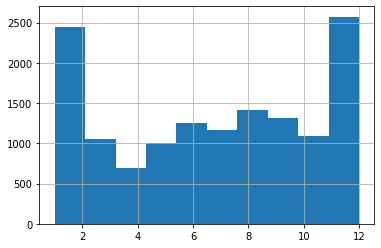

In [67]:
tmp.loc[tmp.target > 0].month.hist()

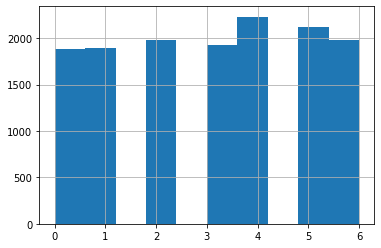

In [68]:
tmp.loc[tmp.target > 0].day_of_week.hist()

In [69]:
tmp.loc[tmp.target > 0].night.value_counts()

False    12765
True      1252
Name: night, dtype: int64

In [70]:
tmp.loc[tmp.target > 1].night.value_counts()

False    2335
True      321
Name: night, dtype: int64

In [71]:
tmp['hour_sin'] = np.sin(2 * np.pi * tmp['hour']/23.0)
tmp['hour_cos'] = np.cos(2 * np.pi * tmp['hour']/23.0)

tmp.head()

,datetime,road_id,road_km,target,lane,lane_count,volume,occupancy,speed,on_crash_part,date,hour,day_of_week,month,night,hour_sin,hour_cos
0,2019-01-01 00:00:00,9,653,1.0,1.000000,1.0,14.0,0.775000,85.400,False,2019-01-01,0,1,1,True,0.000000,1.000000
1,2019-01-01 02:00:00,14,1184,1.0,1.333333,2.0,4.0,0.339844,80.980,False,2019-01-01,2,1,1,True,0.519584,0.854419
2,2019-01-01 04:00:00,14,438,2.0,1.000000,1.0,21.5,0.671875,81.685,False,2019-01-01,4,1,1,True,0.887885,0.460065
3,2019-01-01 05:00:00,14,440,2.0,1.000000,1.0,42.5,1.087891,79.695,False,2019-01-01,5,1,1,False,0.979084,0.203456
4,2019-01-01 10:00:00,9,962,1.0,1.000000,1.0,8.0,0.400000,83.000,False,2019-01-01,10,1,1,False,0.398401,-0.917211


In [72]:
# добавление данных о ремонте дороги на указанном километре
tmp['year'] = tmp['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)
index_repair = tmp[tmp.set_index(['road_km','road_id','year']).index.isin(repair.set_index(['road_km','road_id','year']).index)].index
tmp.loc[index_repair, 'repair'] = True
tmp = tmp.fillna(False)
tmp.head(2)

,datetime,road_id,road_km,target,lane,lane_count,volume,occupancy,speed,on_crash_part,date,hour,day_of_week,month,night,hour_sin,hour_cos,year,repair
0,2019-01-01 00:00:00,9,653,1.0,1.000000,1.0,14.0,0.775000,85.40,False,2019-01-01,0,1,1,True,0.000000,1.000000,2019,False
1,2019-01-01 02:00:00,14,1184,1.0,1.333333,2.0,4.0,0.339844,80.98,False,2019-01-01,2,1,1,True,0.519584,0.854419,2019,False


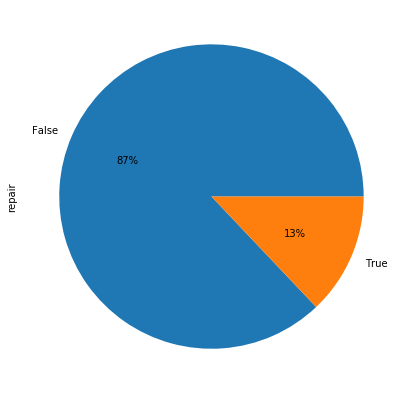

In [73]:
tmp.repair.value_counts().plot(kind = 'pie', figsize = (7, 7), autopct='%1.0f%%');

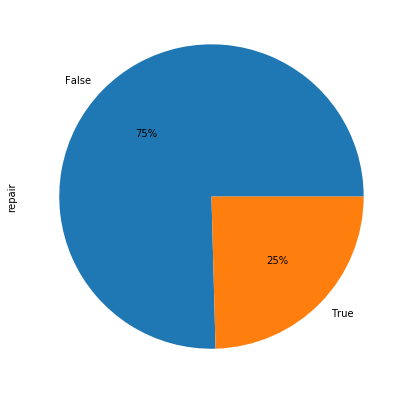

In [74]:
tmp.loc[tmp.target > 0].repair.value_counts().plot(kind = 'pie', figsize = (7, 7), autopct='%1.0f%%');

In [75]:
df.to_pickle('data/train_traffic_crash_datefeat_repair.pickle')

In [76]:
# выбор переменных
columns = ['date',
           'hour_sin',
           'hour_cos',
           'day_of_week',
           'month',
           'night',
           'road_id',
           'road_km',
           'target',
           'volume',
           'occupancy',
           'speed',
           'on_crash_part',
           'lane',
           'lane_count',
           'repair']
tmp = tmp[columns]
tmp.reset_index(drop=True, inplace=True)
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878470 entries, 0 to 878469
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           878470 non-null  object 
 1   hour_sin       878470 non-null  float64
 2   hour_cos       878470 non-null  float64
 3   day_of_week    878470 non-null  int64  
 4   month          878470 non-null  int64  
 5   night          878470 non-null  bool   
 6   road_id        878470 non-null  int64  
 7   road_km        878470 non-null  int64  
 8   target         878470 non-null  float64
 9   volume         878470 non-null  float64
 10  occupancy      878470 non-null  float64
 11  speed          878470 non-null  float64
 12  on_crash_part  878470 non-null  bool   
 13  lane           878470 non-null  float64
 14  lane_count     878470 non-null  float64
 15  repair         878470 non-null  bool   
dtypes: bool(3), float64(8), int64(4), object(1)
memory usage: 89.6+ MB


In [77]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878470 entries, 0 to 878469
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           878470 non-null  object 
 1   hour_sin       878470 non-null  float64
 2   hour_cos       878470 non-null  float64
 3   day_of_week    878470 non-null  int64  
 4   month          878470 non-null  int64  
 5   night          878470 non-null  bool   
 6   road_id        878470 non-null  int64  
 7   road_km        878470 non-null  int64  
 8   target         878470 non-null  float64
 9   volume         878470 non-null  float64
 10  occupancy      878470 non-null  float64
 11  speed          878470 non-null  float64
 12  on_crash_part  878470 non-null  bool   
 13  lane           878470 non-null  float64
 14  lane_count     878470 non-null  float64
 15  repair         878470 non-null  bool   
dtypes: bool(3), float64(8), int64(4), object(1)
memory usage: 89.6+ MB


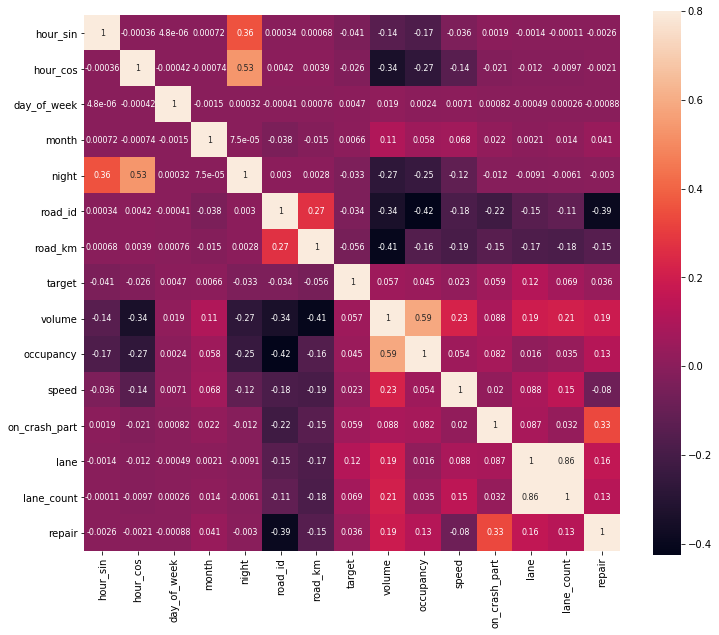

In [78]:
corrmat = tmp.corr()
f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,annot_kws={'size':8})
plt.show()

### 2. Формирование модели. Обучение. Тестирование.

In [79]:
print("Нулевых значений переменной target: ", tmp[tmp['target'] == 0].shape[0])
print("Ненулевых значений переменной target: ", tmp[tmp['target'] != 0].shape[0])

Нулевых значений переменной target:  864453
Ненулевых значений переменной target:  14017


In [80]:
categorical_features = [
 'road_id', 'road_km', 'on_crash_part', 'repair', 'month', 'night', 'day_of_week'
]

numeric_features = ['occupancy', 'lane', 'volume', 'speed', 'hour_sin', 'hour_cos', 'lane_count']

In [81]:
features = categorical_features + numeric_features
df_cb = tmp[features + ['target']]

In [82]:
df_train, df_test = train_test_split(df_cb, random_state=0)

df_train.head()

cat_features_indices = [df_cb.columns.get_loc(c) for c in categorical_features if c in df_cb]

In [83]:
train_pool = Pool(df_train[features].values, label=df_train['target'],
                  cat_features=cat_features_indices)
test_pool = Pool(df_test[features].values, label=df_test['target'],
                 cat_features=cat_features_indices)

model = CatBoostClassifier(
    loss_function = 'MultiClass', 
    iterations = 200,
    auto_class_weights = 'SqrtBalanced',
    early_stopping_rounds = 20,
    verbose = 1
)

In [84]:
model.fit(train_pool)

Learning rate set to 0.429251
0:	learn: 0.6656809	total: 285ms	remaining: 56.6s
1:	learn: 0.4118935	total: 363ms	remaining: 35.9s
2:	learn: 0.2971522	total: 456ms	remaining: 29.9s
3:	learn: 0.2330916	total: 638ms	remaining: 31.3s
4:	learn: 0.1939211	total: 850ms	remaining: 33.2s
5:	learn: 0.1686164	total: 1.05s	remaining: 34s
6:	learn: 0.1540152	total: 1.18s	remaining: 32.6s
7:	learn: 0.1433402	total: 1.32s	remaining: 31.8s
8:	learn: 0.1379277	total: 1.46s	remaining: 30.9s
9:	learn: 0.1337545	total: 1.61s	remaining: 30.7s
10:	learn: 0.1312790	total: 1.74s	remaining: 29.9s
11:	learn: 0.1303454	total: 1.91s	remaining: 29.9s
12:	learn: 0.1276113	total: 2.08s	remaining: 29.9s
13:	learn: 0.1267582	total: 2.26s	remaining: 30s
14:	learn: 0.1261893	total: 2.42s	remaining: 29.9s
15:	learn: 0.1256255	total: 2.55s	remaining: 29.3s
16:	learn: 0.1250995	total: 2.71s	remaining: 29.2s
17:	learn: 0.1246076	total: 2.86s	remaining: 28.9s
18:	learn: 0.1241729	total: 2.96s	remaining: 28.2s
19:	learn: 0.12

In [85]:
metrics = model.eval_metrics(
    data=test_pool,
    metrics=['F1', 'TotalF1'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Feature ranking:
1. feature speed (17.667433)
2. feature volume (17.556068)
3. feature occupancy (15.753435)
4. feature hour_sin (11.210441)
5. feature road_km (11.000172)
6. feature hour_cos (9.618692)
7. feature month (5.101597)
8. feature lane (4.569285)
9. feature lane_count (3.307917)
10. feature road_id (1.275298)
11. feature repair (1.135846)
12. feature night (0.944728)
13. feature on_crash_part (0.589076)
14. feature day_of_week (0.270012)


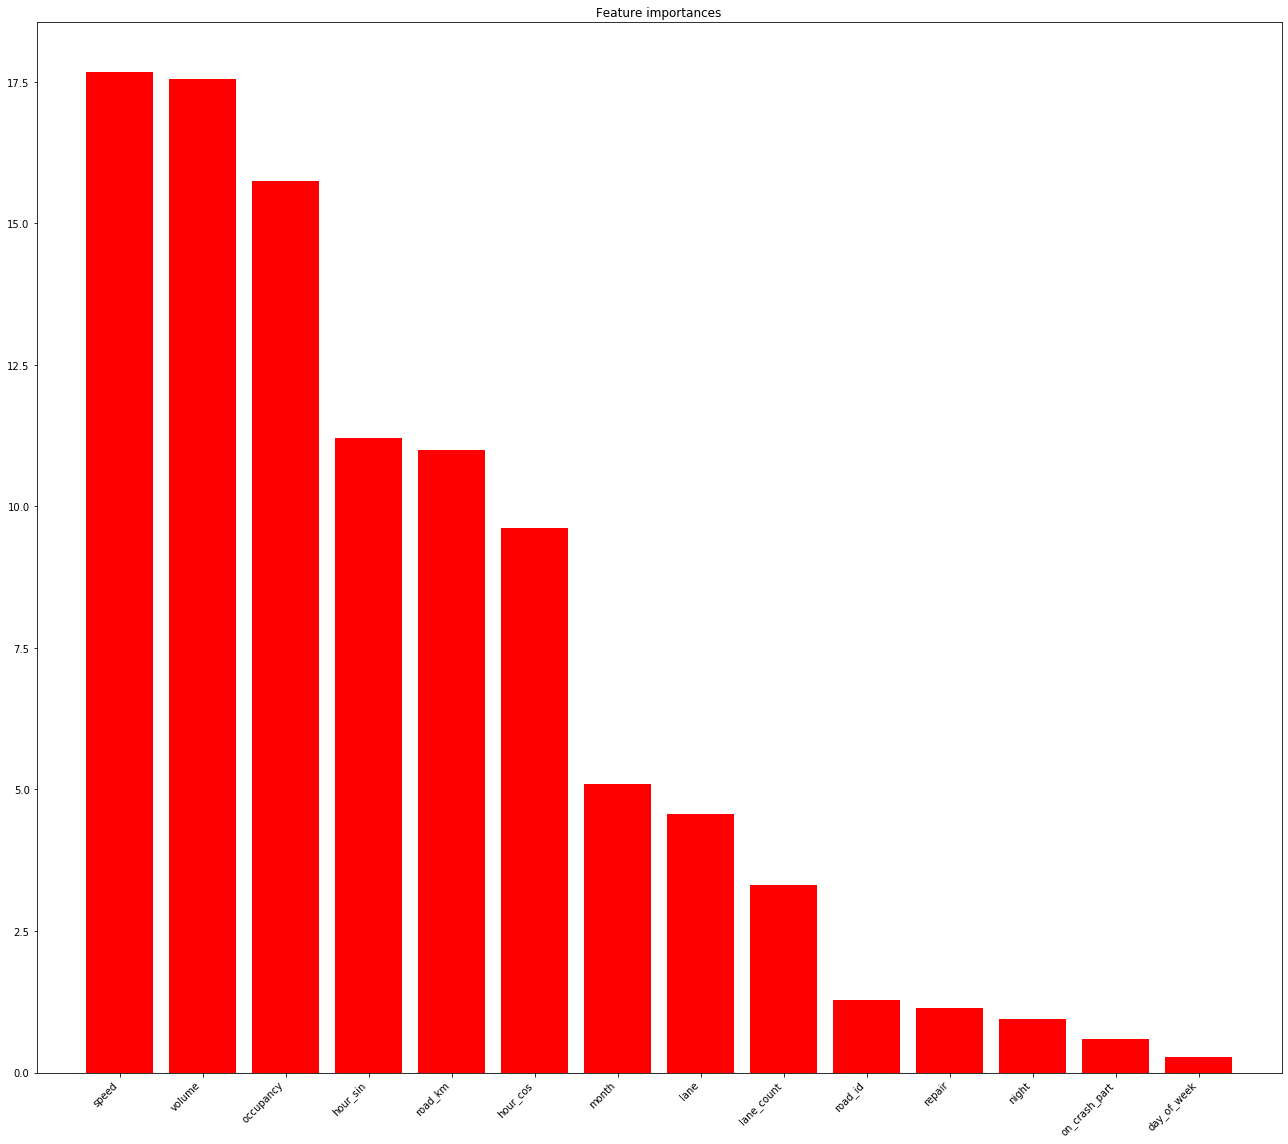

In [86]:
def plot_feature_importance(X, model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    labels = []
    for indice in indices:
        labels.append(feature_names[indice])

    for f in range(X.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(18, 16))
    plt.title("Feature importances")
    plt.bar(range((X.shape[1])), importances[indices],
            color="r", 
            #yerr=std[indices],
            align="center")

    plt.xticks(range(X.shape[1]), labels, rotation = 45, ha='right')
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()
    
plot_feature_importance(df_cb[features], model, features)


### 3. Проверка на основной тестовой выборке (предсказание)

In [87]:
# загрузка выборки
test = pd.read_pickle('data/test-v4.pickle')
test.datetime = test.datetime.swifter.apply(pd.to_datetime)

In [88]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729451 entries, 0 to 1729450
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   datetime  datetime64[ns]
 1   road_id   int64         
 2   road_km   int64         
 3   target    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 52.8 MB


In [89]:
test.head()

,datetime,road_id,road_km,target
0,2020-01-01 01:00:00,9,0,NaN
1,2020-01-01 01:00:00,9,1,NaN
2,2020-01-01 01:00:00,9,2,NaN
3,2020-01-01 01:00:00,9,3,NaN
4,2020-01-01 01:00:00,9,4,NaN


#### Обагащение выборки переменными из датасетов `traffic.csv`, `repair.csv`

In [90]:
# объединение выборки с данными о трафике
test = pd.merge(test, traffic_agg, how='left', on=['datetime', 'road_km','road_id'])
test.head(2)

,datetime,road_id,road_km,target,station_id,lane,lane_count,volume,occupancy,speed
0,2020-01-01 01:00:00,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729451 entries, 0 to 1729450
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   datetime    datetime64[ns]
 1   road_id     int64         
 2   road_km     int64         
 3   target      float64       
 4   station_id  float64       
 5   lane        float64       
 6   lane_count  float64       
 7   volume      float64       
 8   occupancy   float64       
 9   speed       float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 145.1 MB


In [900]:
len(test.loc[test.volume.isna()])

1697924

In [901]:
len(test.loc[test.volume > 0])

31527

In [902]:
#test['lane'], test['lane_count'], test['volume'], test['occupancy'], test['speed'] = zip(*test.swifter.apply(fill_dtp_with_nearest_traffic_rec, axis = 1))

In [903]:
test['on_crash_part'] = test.swifter.apply(is_on_crash_part, axis = 1)
test.head(2)

Dask Apply:   0%|          | 0/128 [00:00<?, ?it/s]

,datetime,road_id,road_km,target,station_id,lane,lane_count,volume,occupancy,speed,on_crash_part
0,2020-01-01 01:00:00,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2020-01-01 01:00:00,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [904]:
test.on_crash_part.value_counts()

False    1688956
True       40495
Name: on_crash_part, dtype: int64

In [905]:
test.loc[test.volume > 0].on_crash_part.value_counts()

False    29898
True      1629
Name: on_crash_part, dtype: int64

In [906]:
# добавление данных о ремонте дороги на указанном километре
test['year'] = test['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)

In [907]:
index_repair = test[test.set_index(['road_km','road_id','year']).index.isin(repair.set_index(['road_km','road_id','year']).index)].index
test.loc[index_repair, 'repair'] = True
test['repair'] = test['repair'].fillna(False)
test.head()

,datetime,road_id,road_km,target,station_id,lane,lane_count,volume,occupancy,speed,on_crash_part,year,repair
0,2020-01-01 01:00:00,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2020,True
1,2020-01-01 01:00:00,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True
2,2020-01-01 01:00:00,9,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True
3,2020-01-01 01:00:00,9,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True
4,2020-01-01 01:00:00,9,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True


In [908]:
test.repair.value_counts()

False    1546289
True      183162
Name: repair, dtype: int64

In [909]:
test.loc[test.volume > 0].repair.value_counts()

False    26441
True      5086
Name: repair, dtype: int64

In [910]:
test["date"] = test["datetime"].dt.date
test["hour"] = test["datetime"].dt.hour
test["day_of_week"] = test["datetime"].dt.dayofweek

test['hour_sin'] = np.sin(2 * np.pi * test['hour']/23.0)
test['hour_cos'] = np.cos(2 * np.pi * test['hour']/23.0)

test["month"] = test["datetime"].dt.month

test['night'] = test.swifter.apply(lambda row: 0 <= row.hour <= 4, axis = 1)

test.head()

Pandas Apply:   0%|          | 0/1729451 [00:00<?, ?it/s]

,datetime,road_id,road_km,target,station_id,lane,lane_count,volume,occupancy,speed,on_crash_part,year,repair,date,hour,day_of_week,hour_sin,hour_cos,month,night
0,2020-01-01 01:00:00,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
1,2020-01-01 01:00:00,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
2,2020-01-01 01:00:00,9,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
3,2020-01-01 01:00:00,9,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
4,2020-01-01 01:00:00,9,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True


In [1077]:
test.to_pickle('data/test_with_stuff.pickle')

In [1076]:
test.head()

,datetime,road_id,road_km,target,station_id,lane,lane_count,volume,occupancy,speed,on_crash_part,year,repair,date,hour,day_of_week,hour_sin,hour_cos,month,night
0,2020-01-01 01:00:00,9,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,False,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
1,2020-01-01 01:00:00,9,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
2,2020-01-01 01:00:00,9,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
3,2020-01-01 01:00:00,9,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True
4,2020-01-01 01:00:00,9,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,True,2020,True,2020-01-01,1,2,0.269797,0.962917,1,True


#### Предсказание и оценка модели

In [1073]:
%%time
# предсказание значений переменной target
test['target'] =  model.predict(test[features + ['target']])

prediction = test[['datetime','road_id','road_km','target']]
prediction.to_csv('data/prediction.csv', index=False)

CPU times: user 13.9 s, sys: 98.9 ms, total: 14 s
Wall time: 8.41 s


In [1075]:
prediction_true = prediction.drop(prediction[prediction['target'] == 0].index)
prediction_true.to_csv('data/mstsc_task3_13.csv')
prediction_true.target.value_counts()

1.0    2701
2.0      78
Name: target, dtype: int64

In [1054]:
model.save_model('data/mstsc_model')